# Consensus clustering and consistency


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import igraph
import leidenalg
import numpy as np
import itertools
import pandas as pd
from nwtools import communities, consensus

In [2]:
g_test = igraph.Graph(directed=False)
node_names = [chr(c) for c in range(ord('A'), ord('H'))]
g_test.add_vertices(node_names)

g_test.add_edges([
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('D', 'F'),
    ('F', 'G'),
    ('D', 'G')
])

In [57]:
partitions = consensus.get_initial_partitions(g_test)
consensus_mat1 = consensus.get_consensus_matrix(partitions, g_test.vcount())
consensus_mat1

array([[1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1.]])

In [3]:
part1 = igraph.clustering.VertexClustering(g_test, [0,0,0,2,2,2,2])
part2 = igraph.clustering.VertexClustering(g_test, [0,0,1,1,1,2,2])
part3 = igraph.clustering.VertexClustering(g_test, [0,0,0,1,1,2,2])

n1 = 40
n2 = 30
n3 = 30

initial_partition = [part1]*n1 + [part2]*n2 + [part3]*n3

In [4]:
color_dict = {0: 'lightblue', 1: 'green', 2: 'red'}
#layout = g_test.layout('kk')
layout = [(0, 1),
          (2, 0),
          (1, 2),
          (0, 3),
          (1, 3),
          (0, 4),
          (2, 4)
         ]
layout = [(y,x) for x,y in layout]

In [5]:
def get_modularity(part, graph):
    return leidenalg.ModularityVertexPartition(graph, initial_membership=part.membership 
                                                 #, weights='weight'
                                              ).quality()

40 partitions, modularity: 0.37


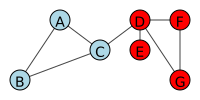

In [6]:
print('{} partitions, modularity: {:.2f}'.format(n1, get_modularity(part1, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part1.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

30 partitions, modularity: 0.12


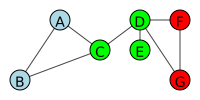

In [7]:
print('{} partitions, modularity: {:.2f}'.format(n2, get_modularity(part2, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part2.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

30 partitions, modularity: 0.27


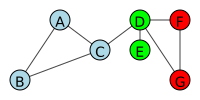

In [8]:
print('{} partitions, modularity: {:.2f}'.format(n3, get_modularity(part3, g_test)))
igraph.plot(g_test, layout=layout, 
            vertex_color = [color_dict[c] for c in part3.membership],
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

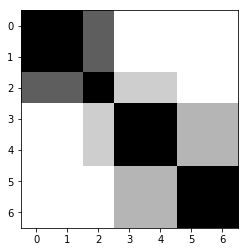

In [9]:
consensus_mat = consensus.get_consensus_matrix(initial_partition, g_test.vcount())
plt.imshow(consensus_mat, cmap='Greys')
#plt.xticks.l(node_names)

In [10]:
def get_edge_consistency(graph, consensus_matrix):
    edge_indices = [e.tuple for e in graph.es]
    ix, jx = zip(*edge_indices)
    graph.es['consensus'] = consensus_matrix[ix, jx]
    graph.es['consistency'] = 2*np.abs(np.array(graph.es['consensus'])-0.5)
    return graph

In [11]:
g_test = get_edge_consistency(g_test, consensus_mat)

In [12]:
consensus_df = pd.DataFrame({'Source': [node_names[e.source] for e in g_test.es],
                             'Target': [node_names[e.target] for e in g_test.es],
                            'consensus': g_test.es['consensus'],
                            'consistency': g_test.es['consistency']})

In [13]:
consensus_df

,Source,Target,consensus,consistency
0,A,B,1.0,1.0
1,A,C,0.7,0.4
2,B,C,0.7,0.4
3,C,D,0.3,0.4
4,D,E,1.0,1.0
5,D,F,0.4,0.2
6,F,G,1.0,1.0
7,D,G,0.4,0.2


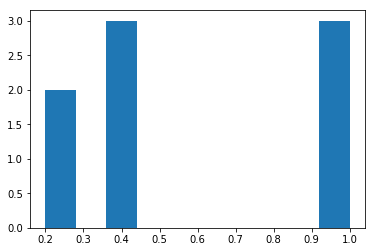

In [14]:
plt.hist(consensus_df.consistency)
plt.show()

Look at consistency compared to reference clustering, e.g. the consensus clustering

In [15]:
reference_part = part1

In [16]:
gain, penalty, contribution = consensus.modularity_contribution(g_test, part1.membership)

In [17]:
pd.DataFrame({'gain': gain, 'penalty': penalty, 'contribution': contribution}, index=node_names)

,gain,penalty,contribution
A,0.250,-0.093750,0.343750
B,0.250,-0.093750,0.343750
C,0.250,-0.128906,0.378906
D,0.375,-0.218750,0.593750
E,0.125,-0.066406,0.191406
F,0.250,-0.125000,0.375000
G,0.250,-0.125000,0.375000


In [38]:
ref_mat = consensus.get_consensus_matrix([reference_part], g_test.vcount())
consensus_within_cluster = ref_mat*consensus_mat
np.fill_diagonal(consensus_within_cluster, 0)
node_consistency_within_cluster = np.sum(consensus_within_cluster, axis=0) / np.sum(consensus_within_cluster>0, axis=0) # This is the mean over all non-zero values per row

In [39]:
g_test.vs['reference_consistency'] = node_consistency_within_cluster

In [22]:
def reference_consistency(reference_part, graph):
    ref_mat = consensus.get_consensus_matrix([reference_part], graph.vcount())
    reference_dif_mat = ref_mat - consensus_mat
    
    edge_indices = [e.tuple for e in graph.es]
    ix, jx = zip(*edge_indices)
    
    reference_dif = reference_dif_mat[ix, jx]
    reference_consistency = 1 - np.abs(np.array(reference_dif))
    return reference_dif, reference_consistency 

In [24]:
reference_dif, reference_consistency = reference_consistency(reference_part, g_test)

In [25]:

g_test.es['reference_dif'] = reference_dif
g_test.es['reference_consistency'] = reference_consistency
consensus_df['reference_dif'] = reference_dif
consensus_df['reference_consistency'] = reference_consistency

In [20]:
consensus_df

,Source,Target,consensus,consistency,reference_dif,reference_consistency
0,A,B,1.0,1.0,0.0,1.0
1,A,C,0.7,0.4,0.3,0.7
2,B,C,0.7,0.4,0.3,0.7
3,C,D,0.3,0.4,-0.3,0.7
4,D,E,1.0,1.0,0.0,1.0
5,D,F,0.4,0.2,0.6,0.4
6,F,G,1.0,1.0,0.0,1.0
7,D,G,0.4,0.2,0.6,0.4


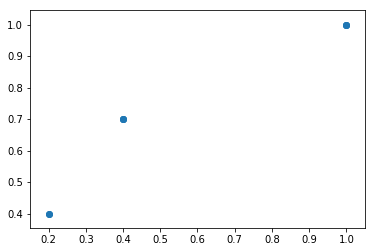

In [21]:
plt.scatter(consensus_df.consistency, consensus_df.reference_consistency)

In [41]:
def get_node_stability(graph, edges_df, thres_list=None):
    suffix = ''
    names = graph.vs.get_attribute_values('name')
    nodes_df = pd.DataFrame(index=names)
    nodes_df['degree'+suffix] = pd.Series(graph.degree(), index=names)
    #nodes_df['weighted_degree'+suffix] = pd.Series(graph.strength(weights='weight'), index=names)
    nodes_df['eigenvector_centrality'+suffix] = pd.Series(
        graph.eigenvector_centrality(directed=False), index=names)
    nodes_df['betweenness'+suffix] = pd.Series(graph.betweenness(directed=False), index=names)
    edges_unstacked = edges_df.consistency.unstack()
    
    stabilities_unstacked = edges_unstacked.add(edges_unstacked.transpose(), fill_value=0)

    nodes_df['consistency_mean'] = stabilities_unstacked.mean(axis=0)
    nodes_df['consistency_min'] = stabilities_unstacked.min(axis=0)
    nodes_df['consistency_max'] = stabilities_unstacked.max(axis=0)
    nodes_df['consistency_std'] = stabilities_unstacked.apply(np.std, axis=0)
    nodes_df['consistency_mean_min_std'] = nodes_df['consistency_mean'] - nodes_df['consistency_std']
    if thres_list is None:
        thres_list = [0.8, 0.9, 1.0]
    for thres in thres_list:
        perc_consistent_neigbors =  (stabilities_unstacked>=thres).sum(axis=0) / (~stabilities_unstacked.isna()).sum(axis=0)
        nodes_df['consistency_neighbors_{:.1f}'.format(thres)] =perc_consistent_neigbors
        
    return nodes_df

In [42]:
node_consistency = get_node_stability(g_test, consensus_df.set_index(['Source', 'Target']),
                                     thres_list=[0.5, 0.65, 1])

In [43]:
node_consistency['ref_consistency_mean_all'] = np.mean(1-np.abs(reference_dif_mat), axis=1)

In [44]:
node_consistency['gain'] = gain
node_consistency['penalty'] = penalty
node_consistency['contribution'] = contribution

In [45]:
node_consistency['reference_consistency'] = node_consistency_within_cluster

In [46]:
node_consistency

,degree,eigenvector_centrality,betweenness,consistency_mean,consistency_min,consistency_max,consistency_std,consistency_mean_min_std,consistency_neighbors_0.5,consistency_neighbors_0.7,consistency_neighbors_1.0,ref_consistency_mean_all,gain,penalty,contribution,reference_consistency
A,2,0.537997,0.0,0.70,0.4,1.0,3.000000e-01,0.400000,0.50,0.50,0.50,0.957143,0.250,-0.093750,0.343750,0.85
B,2,0.537997,0.0,0.70,0.4,1.0,3.000000e-01,0.400000,0.50,0.50,0.50,0.957143,0.250,-0.093750,0.343750,0.85
C,3,0.821524,8.0,0.40,0.4,0.4,5.551115e-17,0.400000,0.00,0.00,0.00,0.828571,0.250,-0.128906,0.378906,0.70
D,4,1.000000,11.0,0.45,0.2,1.0,3.278719e-01,0.122128,0.25,0.25,0.25,0.785714,0.375,-0.218750,0.593750,0.60
E,1,0.395726,0.0,1.00,1.0,1.0,0.000000e+00,1.000000,1.00,1.00,1.00,0.785714,0.125,-0.066406,0.191406,0.60
F,2,0.654877,0.0,0.60,0.2,1.0,4.000000e-01,0.200000,0.50,0.50,0.50,0.828571,0.250,-0.125000,0.375000,0.60
G,2,0.654877,0.0,0.60,0.2,1.0,4.000000e-01,0.200000,0.50,0.50,0.50,0.828571,0.250,-0.125000,0.375000,0.60


(-0.1, 1.1)

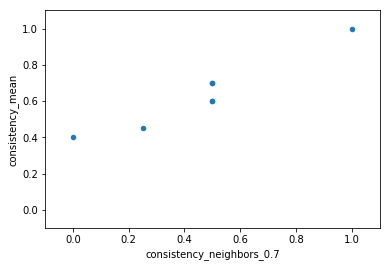

In [47]:
node_consistency.plot('consistency_neighbors_0.7', 'consistency_mean', kind='scatter')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

(-0.1, 1.1)

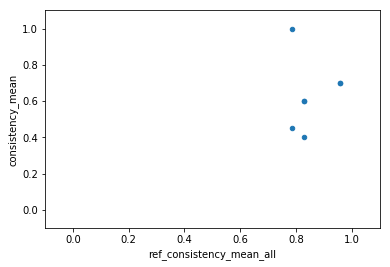

In [48]:
node_consistency.plot('ref_consistency_mean_all', 'consistency_mean', kind='scatter')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

(-0.1, 1.1)

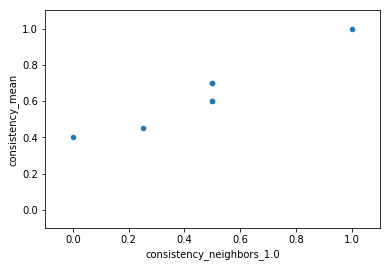

In [49]:
node_consistency.plot('consistency_neighbors_1.0', 'consistency_mean', kind='scatter')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

In [50]:
node_consistency['consistency_neighbors_1.0'].sort_values()

C    0.00
D    0.25
A    0.50
B    0.50
F    0.50
G    0.50
E    1.00
Name: consistency_neighbors_1.0, dtype: float64

In [51]:
node_consistency['consistency_neighbors_0.5'].sort_values()

C    0.00
D    0.25
A    0.50
B    0.50
F    0.50
G    0.50
E    1.00
Name: consistency_neighbors_0.5, dtype: float64

In [52]:
import matplotlib 
cm = matplotlib.cm.get_cmap('Greens')

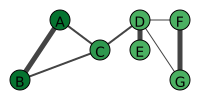

In [53]:
attr = 'reference_consistency' #'consistency_neighbors_0.7'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
            edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

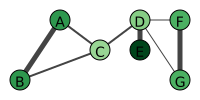

In [38]:
attr = 'consistency_mean' #'consistency_neighbors_0.7'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
            edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

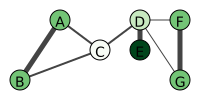

In [39]:
attr = 'consistency_neighbors_1.0'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
             edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

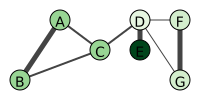

In [40]:
attr = 'consistency_mean_min_std' #'consistency_neighbors_0.7'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
             edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

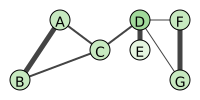

In [41]:
attr = 'gain' #'consistency_neighbors_0.7'
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
             edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))

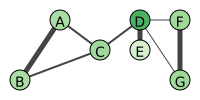

In [54]:
attr = 'contribution' 
igraph.plot(g_test, layout=layout, 
            vertex_color = [cm(c) for c in node_consistency[attr]],
             edge_width = 5*consensus_df.consistency,
            vertex_label = g_test.vs["name"],
           bbox=(0,0,200,100))